<a href="https://colab.research.google.com/github/cryptobellum/Unit-2-Build-week-app/blob/main/Unit_2_Build_Week_Crossfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Which Crossfit Athletes Have Competitive Potential in the Sport of Weightlifting?**

**Links:** Blog: https://medium.com/@Cryptobellum/which-crossfit-athletes-have-competitive-potential-for-the-sport-of-weightlifting-4d233cca44dd

Dataset originally compiled by Sam Swift and later made available by Brandon Gadoci at https://data.world/bgadoci/crossfit-data

In [1]:
%%capture
!pip install category_encoders
!pip install pdpbox

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import category_encoders as ce 
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

In [2]:
data_url = 'https://query.data.world/s/dbkcq4idvugkfhoyx4ngann5ycr4jl'

In [3]:
import pandas as pd
df = pd.read_csv(data_url)

In [4]:
print(df.shape)
df.head()

(423006, 28)


,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong,retrieved_datetime
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|,NaN
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|,NaN
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,245.0,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|,NaN
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,465.0,NaN,1053.0,NaN,NaN,1081.0,205.0,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|,NaN


In [5]:
#Generate Pandas Profiling Report
#!pip install pandas-profiling==2.*
#import pandas_profiling
#df.profile_report()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423006 entries, 0 to 423005
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   athlete_id          423003 non-null  float64
 1   name                331110 non-null  object 
 2   region              251262 non-null  object 
 3   team                155160 non-null  object 
 4   affiliate           241916 non-null  object 
 5   gender              331110 non-null  object 
 6   age                 331110 non-null  float64
 7   height              159869 non-null  float64
 8   weight              229890 non-null  float64
 9   fran                55426 non-null   float64
 10  helen               30279 non-null   float64
 11  grace               40745 non-null   float64
 12  filthy50            19359 non-null   float64
 13  fgonebad            29738 non-null   float64
 14  run400              22246 non-null   float64
 15  run5k               36097 non-null

In [7]:
df.select_dtypes('object').nunique().sort_values()

gender                     3
region                    17
howlong                   30
background                43
eat                       47
train                     83
experience                84
schedule                 134
team                    4532
affiliate               9778
retrieved_datetime    190785
name                  306752
dtype: int64

In [8]:
df['deadlift'].value_counts()

405.0     5228
0.0       3685
365.0     3359
375.0     3305
425.0     2948
          ... 
101.0        1
87.0         1
59.0         1
1225.0       1
371.0        1
Name: deadlift, Length: 629, dtype: int64

In [9]:
#determining outliers for Olympic lifts (snatch and clean and jerk) and compound lifts(back squat and deadlift)
print(df.loc[df['gender'] == 'Female', 'deadlift'].min())
print(df.loc[df['gender'] == 'Female', 'deadlift'].max())
print(df.loc[df['gender'] == 'Male', 'deadlift'].min())
print(df.loc[df['gender'] == 'Male', 'deadlift'].max())
print(df.loc[df['gender'] == 'Female', 'backsq'].min())
print(df.loc[df['gender'] == 'Female', 'backsq'].max())
print(df.loc[df['gender'] == 'Male', 'backsq'].min())
print(df.loc[df['gender'] == 'Male', 'backsq'].max())
print(df.loc[df['gender'] == 'Female', 'candj'].min())
print(df.loc[df['gender'] == 'Female', 'candj'].max())
print(df.loc[df['gender'] == 'Female', 'snatch'].min())
print(df.loc[df['gender'] == 'Female', 'snatch'].max())
print(df.loc[df['gender'] == 'Male', 'candj'].min())
print(df.loc[df['gender'] == 'Male', 'candj'].max())
print(df.loc[df['gender'] == 'Male', 'snatch'].min())
print(df.loc[df['gender'] == 'Male', 'snatch'].max())

0.0
8388607.0
-500.0
8388607.0
0.0
135000.0
-7.0
8388607.0
0.0
1555.0
0.0
145155.0
-45.0
8388607.0
0.0
8388607.0


# **Exploratory Data Analysis and Data Preprocessing**


*   Remove rows that contain a null value in both the snatch and candj columns
*   Remove rows containing null values in these columns: snatch, candj, backsq, deadlift
*   Remove rows that contain nulls in all columns
*   Remove rows that contain outlier values for clj, snatch, bsq, and deadlift.
      I'm basing this threshold on what hasn't been humanly possible so far. Any value existing beyond the men's or women's world record in these lifts. Dropping outlier values on the lower end using the minimum weight for the women's bar of 33 pounds because even injured individuals who desire to participate will, at minimum, lift the bar

In [10]:
def wrangle(df):
  df = df.copy()

  #Drop rows that contain null values in every column
  df.dropna(axis=0,how='all', inplace=True)

  #Drop rows that contain an outlier value for 'snatch' column where column is 'male'
  male_sn = df[(df['gender'] == 'Male') & (df['snatch'] >= 500)].index
  df.drop(male_sn , inplace=True)

  #Drop rows that contain an outlier value for 'candj' column where column is 'male'
  male_cj = df[(df['gender'] == 'Male') & (df['candj'] >= 600)].index
  df.drop(male_cj , inplace=True)

  #Drop rows that contain an outlier value for 'backsq' column where column is 'male'
  male_bsq = df[(df['gender'] == 'Male') & (df['backsq'] >= 1160)].index
  df.drop(male_bsq , inplace=True)

  #Drop rows that contain an outlier value for 'deadlift' column where column is 'male' I'm eliminating values that are (beyond the world record deadlift
  #amount(1110) 
  male_dl = df[(df['gender'] == 'Male') & (df['deadlift'] >= 1110)].index
  df.drop(male_dl , inplace=True)

  #Drop rows that contain an outlier value for 'snatch' column where column is 'female'
  female_sn = df[(df['gender'] == 'Female') & (df['snatch'] >= 355)].index
  df.drop(female_sn , inplace=True)

  #Drop rows that contain an outlier value for 'candj' column where column is 'female'
  female_cj = df[(df['gender'] == 'Female') & (df['candj'] >= 435)].index
  df.drop(female_cj , inplace=True)

  #Drop rows that contain an outlier value for 'backsq' column where column is 'female'
  female_bsq = df[(df['gender'] == 'Female') & (df['backsq'] >= 603)].index
  df.drop(female_bsq , inplace=True)

  #Drop rows that contain an outlier value for 'deadlift' column where column is 'female' and again similar to the male deadlift, I am dropping
  #outliers that are above the world record female deadlift
  female_dl = df[(df['gender'] == 'Female') & (df['deadlift'] >= 683)].index
  df.drop(female_dl , inplace=True)

  df.dropna(subset = ['snatch', 'candj', 'deadlift', 'backsq'], how='any', inplace=True)

  #Drop rows that contain an outlier value for 'age' column. I'm definining an outlier value as
  # anything above 65. While the sport of Olympic weightlifting is very inclusive and offers competition age divisions for everyone
  #it is less meaningful to evaluate competitive "potential" in the sport beyond a certain point where there is not much variation in performance.
  #Beyond a certain age, simply showing up and competing is remarkable in its own right
  age_limit_upper = df[(df['age'] >= 65)].index 
  df.drop(age_limit_upper, inplace=True)
 
  #Drop rows where the athlete is not an adult
  age_limit_lower = df[(df['age'] < 18)].index 
  df.drop(age_limit_lower, inplace=True)
  #Replace the content of background with the number of words it contains
  #df['background_count'] = df['background'].str.split(' ').str.len()

  #drop rows in candj, snatch, backsq, and deadlift columns that are below the minimum weight of the women's bar
  #a severely injured participant who still desire to participate would at least lift the bar without any weights loaded on it
  
  lift_subset = df[(df['backsq'] <= 33) | (df['deadlift'] <= 33) | (df['candj'] <= 33) | (df['snatch'] <= 33)].index
  df.drop(lift_subset, inplace=True)  
                                                                                                                       
  return df



In [11]:
df = wrangle(df)

In [12]:
print(df.shape)
df.head(1)

(81161, 28)


,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong,retrieved_datetime
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,245.0,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|,NaN


**Examples of Checks Used to Confirm Results of Wrangle Functions**

In [13]:
#This is one example of the type of checks I ran after implementing the wrangle function above to make sure my code produced desired results, 
#and the changes took effect. I eliminated many of these checks in this final notebook in an effort to present a clean, final notebook for submission.
print(df.loc[df['gender'] == 'Female', 'deadlift'].min())
print(df.loc[df['gender'] == 'Female', 'deadlift'].max())
print(df.loc[df['gender'] == 'Male', 'deadlift'].min())
print(df.loc[df['gender'] == 'Male', 'deadlift'].max())
print()
df['age'].sort_values(ascending=False)

35.0
675.0
35.0
1091.0



387367    56.0
374021    56.0
364410    56.0
364435    56.0
404129    56.0
          ... 
286717    18.0
183165    18.0
32183     18.0
143269    18.0
202094    18.0
Name: age, Length: 81161, dtype: float64

**Since I am interested in determining which Crossfit athletes have potential to be competitive in the sport of Weightlifting, 
my target ['talent'] is going to be a feature that I engineer based on domain-specific knowledge. The new feature calculates the ratio of clean-and-jerk to backsquat, which demonstrates a minimum threshold for the necessary technique needed for successful competitive performance in Weightlifting. A ratio above this threshold demonstrates that the lifter is skilled at maximizing their overall strength, and it is an indication of more optimized technique. My expectation is that someone who is identified as having competitive "Potential" could qualify for nationals within two years of consistent training in the sport of Weightlifting. After, I will drop the features used to engineer this target feature in order to prevent leakage.**

In [14]:
df["clj_to_bsq_ratio"] = df['candj']/df['backsq']

In [15]:
def weightlifting_potential(row):
    if row['clj_to_bsq_ratio'] >= .70:
        return 'potential'
    #elif row['clj_to_bsq_ratio'] < .77 and row['clj_to_bsq_ratio']  >= .72:
     #   return 'some potential'
    else:
        return 'no potential'

In [16]:
df['talent'] = df.apply(weightlifting_potential, axis=1)

In [17]:
df['sn_clj'] = df['snatch']/df['candj']

In [18]:
def sn_to_clj_ratio(row):
  if row['sn_clj'] >=.78 + row['sn_clj'] <=.84:
      return 'ideal'
  else:
        return 'not ideal'

In [19]:
df["snatch_clj"] = df.apply(sn_to_clj_ratio, axis=1)

**In an effort to derive a greater degree of meaningfulness from some existing features in the dataset, I'm feature engineering a column that captures part of the psychological aspects of sports performance. One of the selected options for the 'training' column included whether CF athletes have had a life changing experience due to Crossfit. It seems counterintuitive, but my expectation is that athletes more inclined to view their experience with Crossfit as life changing would have a greater likelihood of falling into the "No Potential" target category. Part of my feature engineering strategy explained below particularly for dealing with missing values, is based on a possible scenario of having a real-world client who requests that I don't exclude a feature just because it has a lot of missing values (in a few of these cases, the rate was between 25-35%)**

In [20]:
def wrangle_two(df):
  df = df.copy()
  #Create a new column equal to True or False depending on whether or not an athlete described their experience with Crossfit as life changing
  df['experience_type'] = df['experience'].str.contains('life changing') 
  #Replance NaN values with False. This is an appropriate replacement in my attempts to feature engineer this binary column. If an athlete did not
  #respond to the question, then the likelihood that they had a profound experience is greatly reduced.
  df['experience_type'] = df['experience_type'].fillna(False)
  #Create a new column that takes the 'background' column and converts it to a binary classification based on whether or
  #not the athlete had a prior athletic background
  df['background_type'] = df['background'].str.contains('no athletic background besides CrossFit')
  #Replacing NaNs values with value that is most reasonable to avoid needing to impute later with most common value In this case,
  #replacing NaN values with True based on likelihood that athletes with prior athletic experience would be more likely to respond to this question
  #and less likely to acknowledge that they have no prior athletic background
  df['background_type'] = df['background_type'].fillna(True)
  #Replacing 'schedule' column with a binary classification honing in on whether an athlete works out multiple times a day. My reasoning is 
  #that athletes who are willing to work out multiple times a day have a greater competitive advantage
  df['schedule_type'] = df['schedule'].str.contains('I do multiple workouts in a day 3+ times a week') 
  #Again, replacing NaN values upfront based on reasonable assessment to avoid less-than-ideal imputation results in my pipeline later
  df['schedule_type'] = df['schedule_type'].fillna(False)
  #Create a new column that is a binary classification of 
  df['train_description'] = df['train'].str.contains('I workout mostly at a CrossFit Affiliate') 
  df['train_description'] = df['train_description'].fillna(False)
  #Drop columns that are no longer needed and particularly columns used to derive engineered features to eliminate later potential leakage
  #or contrived high correlation
  df = df.drop(columns=['candj', 'backsq', 'retrieved_datetime', 'clj_to_bsq_ratio', 'athlete_id', 'name', 'sn_clj','background', 'schedule', 'train'])
  return df

In [21]:
df = wrangle_two(df)

In [22]:
df['talent'].value_counts(normalize=True)

potential       0.516763
no potential    0.483237
Name: talent, dtype: float64

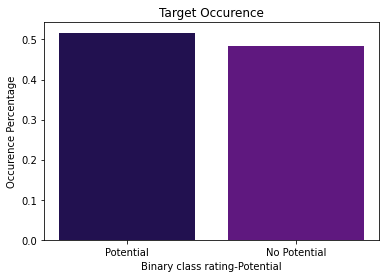

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.bar(['Potential', 'No Potential'], df['talent'].value_counts(normalize=True), color=sns.color_palette("magma"))
plt.title('Target Occurence')
plt.ylabel('Occurence Percentage')
plt.xlabel('Binary class rating-Potential');

# **Split Data**

In [24]:
target = 'talent'
y = df[target]
X = df.drop(target, axis=1)

In [25]:
features= ['age', 'train_description', 'background_type', 'experience_type', 'region', 'snatch', 'deadlift', 'snatch_clj', 'schedule_type', 'eat']

X_new = X[features]

In [26]:
# Import the train_test_split utility
#from sklearn.model_selection import train_test_split
# Create the "remaining" and test datasets
from sklearn.model_selection import train_test_split

X_initial_train, X_test, y_initial_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42)

In [27]:
X_initial_train.shape, y_initial_train.shape, X_test.shape, y_test.shape

((64928, 10), (64928,), (16233, 10), (16233,))

In [28]:
# Create the train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_initial_train, y_initial_train, test_size=0.2, random_state=42)

In [29]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((51942, 10), (51942,), (12986, 10), (12986,), (16233, 10), (16233,))

# **Establish Baseline**

In [30]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5175772977551885


# **Build Models**

*   Logistic Regression
*   Random Forest Classifier
*   XGBoostClassifier






# **Logistic Regression** 
  -To meet rubric Objective "Fit and evaluate any linear model"

In [31]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce 
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer


model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()
)

In [32]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region', 'snatch_clj', 'eat'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'region',
                                          'data_type': dtype('O'),
                                          'mapping': North West              1
Mid Atlantic            2
Northern California     3
Canada West             4
South East              5
NaN                     6
Australia               7
Europe                  8
North East              9
Canada East            10
North Central          11
Latin Ameri...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticReg

# **Random Forest Classifier**
  -To meet rubric Objective "Fit and evaluate a tree-based model"

In [33]:
model_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=6)
)

#fit on train, score on val 
model_rf.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region', 'snatch_clj', 'eat'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'region',
                                          'data_type': dtype('O'),
                                          'mapping': North West              1
Mid Atlantic            2
Northern California     3
Canada West             4
South East              5
NaN                     6
Australia               7
Europe                  8
North East              9
Canada East            10
North Central          11
Latin Ameri...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=6, max_features='auto',
                                     

# **XGBoost Classifier**
-Additionally, to meet rubric Objective "Fit and evaluate a tree-based model"

In [34]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=41, n_jobs=-1)
)

model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region', 'snatch_clj', 'eat'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'region',
                                          'data_type': dtype('O'),
                                          'mapping': North West              1
Mid Atlantic            2
Northern California     3
Canada West             4
South East              5
NaN                     6
Australia               7
Europe                  8
North East              9
Canada East            10
North Central          11
Latin Ameri...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_st

**PDP Interact Plot for features 'deadlift' and 'snatch' from XGBoost Classifer**

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


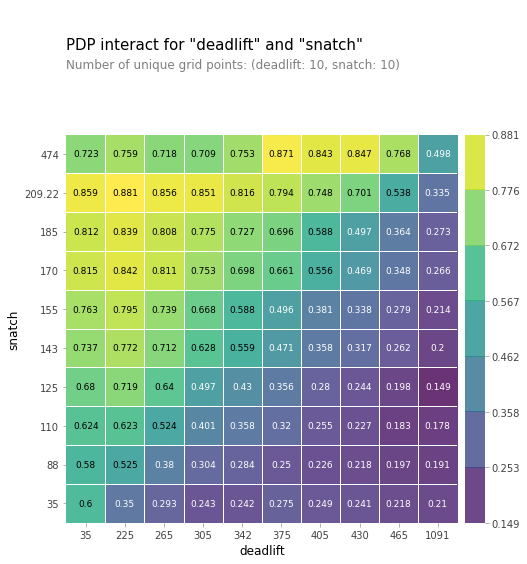

In [35]:
features= ['deadlift', 'snatch']

interact= pdp_interact(
    model=model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

**The above PDP Interact Plot shows a somewhat even expansion of purple along the X axis and the y axis. The athletes with lowest potential have a very high deadlift but can only lift a very small number of pounds for the snatch lift. For an athlete to realize his or her full strength potential, the snatch should roughly be about 40% of the deadlift. It is not uncommon for CrossFit athletes to have ratios that are far different from ideal, which presents a particular challenge identifying individuals who have potential for competitive Weightlifting.**

# **Check Metrics**

**Logistic Regression**

In [36]:
#Logistic Regression-Training/Validation Accuracy
train_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_val, model.predict(X_val))
print('Logistic Regression Training Accuracy Score:', train_acc)
print('Logistic Regression Validation Accuracy Score:', val_acc)

Logistic Regression Training Accuracy Score: 0.639328481768126
Logistic Regression Validation Accuracy Score: 0.6383797936239026


**Random Forest Classifier**

In [37]:
train_acc =  accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))
print('Random Forest Classifier Training Accuracy Score:', train_acc)
print('Random Forest Classifier Validation Accuracy Score:', val_acc)

Random Forest Classifier Training Accuracy Score: 0.6220399676562319
Random Forest Classifier Validation Accuracy Score: 0.6140458955798552


**XGBoost Classifier**

In [39]:
train_acc =  accuracy_score(y_train, model_xgb.predict(X_train))
val_acc = accuracy_score(y_val, model_xgb.predict(X_val))
print('XGBoost Classifier Training Accuracy Score:', train_acc)
print('XGBoost Classifier Validation Accuracy Score:', val_acc)

XGBoost Classifier Training Accuracy Score: 0.6473181625659389
XGBoost Classifier Validation Accuracy Score: 0.6396888957338672


Based on these metrics displayed above, it looks as if the XGB Classifier has slightly better performance than the Logistic Regression model.

# **Classification Reports**

# **Logistic Regression**

In [40]:
print('Logistic Regression')
print(classification_report(y_val, model.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

no potential       0.64      0.60      0.62      6317
   potential       0.64      0.67      0.66      6669

    accuracy                           0.64     12986
   macro avg       0.64      0.64      0.64     12986
weighted avg       0.64      0.64      0.64     12986



# **Random Forest Classifier**

In [41]:
print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

no potential       0.61      0.56      0.58      6317
   potential       0.61      0.67      0.64      6669

    accuracy                           0.61     12986
   macro avg       0.61      0.61      0.61     12986
weighted avg       0.61      0.61      0.61     12986



# **XGBoost Classifier**

In [42]:
print('XGB Classifier')
print(classification_report(y_val, model_xgb.predict(X_val)))

XGB Classifier
              precision    recall  f1-score   support

no potential       0.64      0.61      0.62      6317
   potential       0.64      0.67      0.66      6669

    accuracy                           0.64     12986
   macro avg       0.64      0.64      0.64     12986
weighted avg       0.64      0.64      0.64     12986



# **Feature Importances**

**Random Forest Classifier**

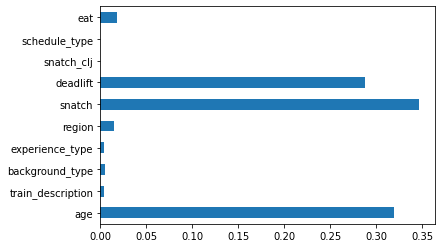

In [43]:
importance = model_rf.named_steps['randomforestclassifier'].feature_importances_
feat_names = model_rf.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importance, index=feat_names)
plt.show()
feat_imp.plot(kind='barh')

**XGBoost**

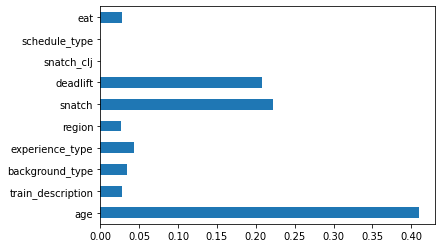

In [44]:
importance = model_xgb.named_steps['xgbclassifier'].feature_importances_
feat_names = model_xgb.named_steps['ordinalencoder'].get_feature_names()
feat_imp = pd.Series(importance, index=feat_names)
feat_imp.plot(kind='barh');

# **Confusion Matrix**

**Logistic Regression**
  This model has 4500 true positives, 3790 true negatives, 2527 false positives, and 2169 false negatives. For casual readers, this confusion matrix is based on the validation data set. So, that is the reason that there are only a total of 12,986 observations even though the dataset after data preprocessing had over 81,000 observations; the validation dataset is a subset of that.

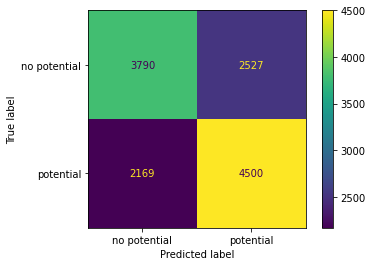

In [45]:
plot_confusion_matrix(model, X_val, y_val, values_format='.0f');

**Random Forest Classifier**
This model has 4455 true positives, 3519 true negatives, 2798 false positives, and 2214 false negatives.

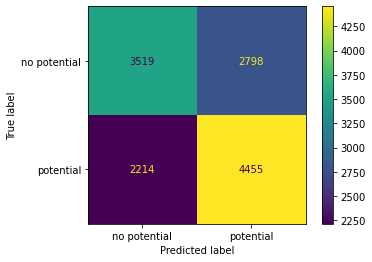

In [46]:
plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f');

**XGBoost Classifier**
This model has 4479 true positives, 3828 true negatives, 2489 false positives, and 2190 false negatives. This model performed best, having the highest number of true positives and true negatives combined(the Logistic Regression model had the highest number of true positives alone), and the lowest number of false posiitves and false negatives combined(the Logistic Regression model had the lowest number of false negatives alone).

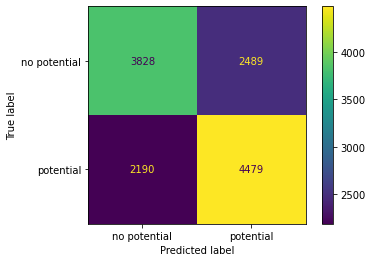

In [47]:
plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f');


# **Hyperparameter Tuning**

**Tuning Logistic Regression by Hand**

In [49]:
model_lr_rscv = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression(random_state=42,  
                       n_jobs=-1,
                       solver='liblinear',
                       penalty='l2')
)

In [50]:
model_lr_rscv.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['region', 'snatch_clj', 'eat'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'region',
                                          'data_type': dtype('O'),
                                          'mapping': North West              1
Mid Atlantic            2
Northern California     3
Canada West             4
South East              5
NaN                     6
Australia               7
Europe                  8
North East              9
Canada East            10
North Central          11
Latin Ameri...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticReg

**Tuning Random Forest Classifier using Randomized Search CV**

In [51]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42,
                           n_jobs=-1)
)

params = {
    'randomforestclassifier__max_depth': range(5,36,10),
    'randomforestclassifier__n_estimators':[25,50,75],
    'randomforestclassifier__max_samples': np.arange(0.2,0.8,0.2)
}

model_rfc_rscv = RandomizedSearchCV(pipeline,
                     param_distributions=params,
                     n_iter=5,
                     n_jobs=-1,
                     cv=5,
                     random_state=42,
                     verbose=1)

In [52]:
model_rfc_rscv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.6s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


**Tuning XGBClassifier Using Randomized Search CV**

In [53]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42,
                           n_jobs=-1)
)

params = {
    'xgbclassifier__max_depth': range(3,19,6),
    'xgbclassifier__learning_rate':[0.05],
    'xgbclassifier__n_estimators':[500],
    'xgbclassifier__max_samples': np.arange(0.2,0.8,0.2),
    'xgbclassifier__early_stopping_rounds': [10]
}

model_xgb_rscv = RandomizedSearchCV(pipeline,
                     param_distributions=params,
                     n_iter=5,
                     n_jobs=-1,
                     cv=5,
                     random_state=42,
                     verbose=1)
      

In [54]:
model_xgb_rscv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


# **Check Metrics for Hyperparameter-tuned Models**

**Logistic Regression model**

In [55]:
train_acc =  accuracy_score(y_train, model_lr_rscv.predict(X_train))
val_acc = accuracy_score(y_val, model_lr_rscv.predict(X_val))
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)



Training Accuracy Score: 0.6396172654114204
Validation Accuracy Score: 0.6384567996303712


**Random Forest Classifier**

In [56]:
train_acc =  accuracy_score(y_train, model_rfc_rscv.predict(X_train))
val_acc = accuracy_score(y_val, model_rfc_rscv.predict(X_val))
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8162373416503023
Validation Accuracy Score: 0.6208224241490836


**XGBoost Classifier**

In [57]:
train_acc =  accuracy_score(y_train, model_xgb_rscv.predict(X_train))
val_acc = accuracy_score(y_val, model_xgb_rscv.predict(X_val))
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.6518809441299911
Validation Accuracy Score: 0.6412290158632373


Again, it appears that on the validation data, the hypertuned models rank the same as before tuning in order of performance: XGBoost, followed by Logistic Regression, with Random Classifier coming in last. However, there are not very big differences in performance, with only a performance boost of 2% points between best and worst models.

# **Communicate Results**

**Partial Dependence Plot for feature 'Age' from Hyperparameter-tuned Random Classifier Model**

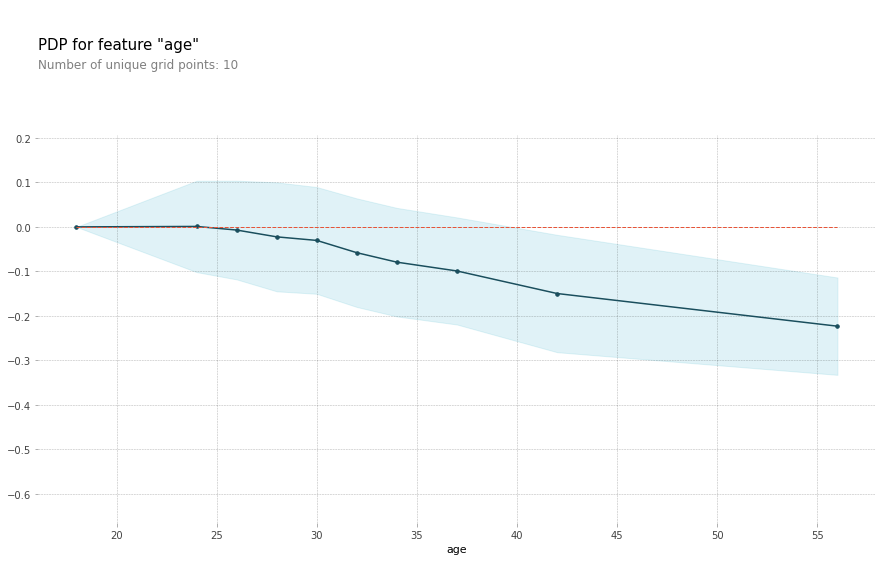

In [59]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature= 'age'

isolate= pdp_isolate(
    model=model_rfc_rscv,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

**Partial Dependence Plot for feature 'Deadlift' from Hyperparameter-tuned Random Classifier Model**

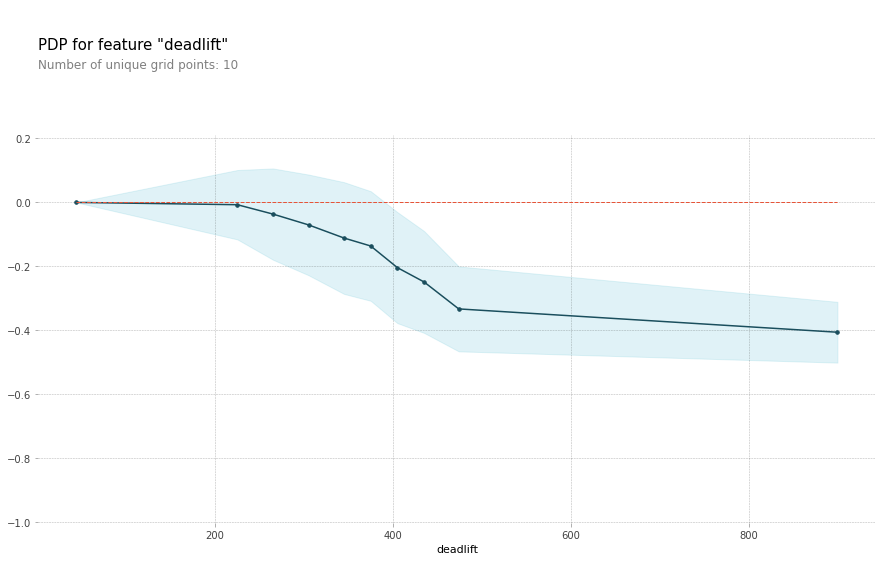

In [60]:
feature= 'deadlift'

isolate= pdp_isolate(
    model=model_rfc_rscv,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

**PDP Interact Plot for features 'deadlift' and 'age' from XGBoost Classifer**

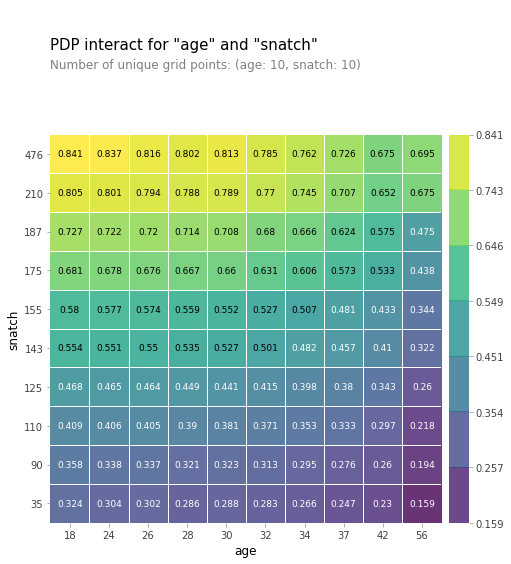

In [61]:
features= ['age', 'snatch']

interact= pdp_interact(
    model=model_xgb,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

The results of this PDP Interact Plot are not surprising. The oldest individual(s) has the lightest weight snatch and has the least potential; the youngest individual has the heaviest weight snatch and has the highest potential. 

**ROC Curve for Tuned Logistic Regression and Random Forest models**

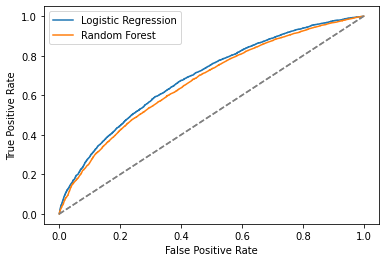

In [62]:
from sklearn.metrics import roc_curve, plot_roc_curve
lr = plot_roc_curve(model_lr_rscv,
                    X_val,
                    y_val,
                    label='Logistic Regression')
rf = plot_roc_curve(model_rfc_rscv,
                    X_val,
                    y_val,
                    ax=lr.ax_,
                    label='Random Forest')

plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

**ROC Curve for XGBoost Classifier model before and after tuning**

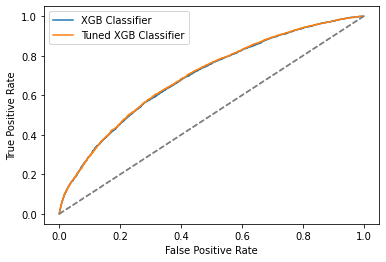

In [63]:
xgb = plot_roc_curve(model_xgb,
                    X_val,
                    y_val,
                    label='XGB Classifier')

xgb2 = plot_roc_curve(model_xgb_rscv,
                    X_val,
                    y_val,
                    ax=xgb.ax_,
                    label='Tuned XGB Classifier')


plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

**As you can see from the above ROC curve, the orange line completely obscures the blue line, as the XGBoost Classifier performed very similarly to the  hyperparameter-tuned XGBoost Classifier on the validation data.**

# **Predictions**

# **Initial Models**

**Logistic Regression**

In [67]:
test_acc =  accuracy_score(y_test, model.predict(X_test))

print('Logistic Regression Testing Accuracy Score:', test_acc)

Logistic Regression Testing Accuracy Score: 0.6374668884371343


**Random Forest Classifier**

In [65]:
test_acc =  accuracy_score(y_test, model_rf.predict(X_test))

print('Random Forest Classifier Testing Accuracy Score:', test_acc)

Random Forest Classifier Testing Accuracy Score: 0.6163986940183577


**XGBoost Classifier**

In [66]:
test_acc =  accuracy_score(y_test, model_xgb.predict(X_test))

print('XGBoost Classifier Testing Accuracy Score:', test_acc)

XGBoost Classifier Testing Accuracy Score: 0.6422103123267419


# **Tuned Models**

**Logistic Regression Model Tuned by Hand**

In [69]:
test_acc =  accuracy_score(y_test, model_lr_rscv.predict(X_test))

print('Random Forest Classifier (Hyperparameter Tuned):', test_acc)

Random Forest Classifier (Hyperparameter Tuned): 0.6377749029754204


**Randomized Forest Classifier Tuned with Randomized Search CV**

In [70]:
test_acc =  accuracy_score(y_test, model_rfc_rscv.predict(X_test))

print('Random Forest Classifier (Hyperparameter Tuned):', test_acc)

Random Forest Classifier (Hyperparameter Tuned): 0.6239142487525411


**XGBoost Classifier Tuned with Randomized Search CV**

In [71]:
test_acc =  accuracy_score(y_test, model_xgb_rscv.predict(X_test))

print('XGBoost Classifier (Hyperparameter Tuned):', test_acc)

XGBoost Classifier (Hyperparameter Tuned): 0.6422719152343991
